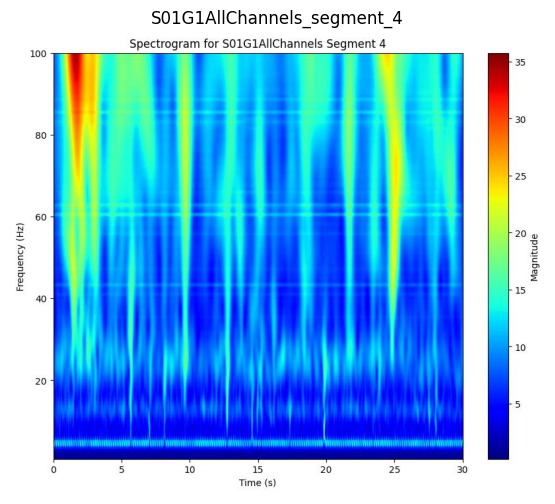

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Path to the image
image_path = '/kaggle/input/gameemo-spectrogram/S01G1AllChannels_segment_4.jpg'

# Load and display the image
img = mpimg.imread(image_path)
plt.figure(figsize=(8, 6))
plt.imshow(img)
plt.axis('off')  # Hide axes for better visualization
plt.title("S01G1AllChannels_segment_4")
plt.show()


In [2]:
import os
import shutil
from zipfile import ZipFile

# Path to the dataset
dataset_path = '/kaggle/input/gameemo-spectrogram'

# Create folders for each game class
output_folders = ['G1', 'G2', 'G3', 'G4']
for folder in output_folders:
    os.makedirs(folder, exist_ok=True)

# Sort files into the respective folders
for filename in os.listdir(dataset_path):
    if filename.endswith('.jpg'):  # Only process .jpg files
        for game_class in output_folders:
            if game_class in filename:
                shutil.copy(os.path.join(dataset_path, filename), game_class)
                break

# Create zip files for each folder
for folder in output_folders:
    zip_filename = f'{folder}.zip'
    with ZipFile(zip_filename, 'w') as zipf:
        for root, _, files in os.walk(folder):
            for file in files:
                zipf.write(os.path.join(root, file), arcname=os.path.join(folder, file))

print("Files sorted and zipped successfully!")


Files sorted and zipped successfully!


**Work**

In [3]:
!pip install PyQt5
!pip install PySide2


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 57.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.8/59.8 MB 28.4 MB/s eta 0:00:00:00:01:010m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.8/270.8 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.3/164.3 MB 10.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 975.4/975.4 kB 42.3 MB/s eta 0:00:00


In [4]:
!pip install snntorch


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.3/125.3 kB 3.7 MB/s eta 0:00:00


In [5]:
import os
import random
import mne
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import scipy.signal as signal
%matplotlib inline

from sklearn.metrics import mean_squared_error, accuracy_score, precision_score
from scipy.stats import pearsonr
from sklearn.metrics.pairwise import cosine_similarity
from skimage.metrics import structural_similarity as ssim
from sklearn.model_selection import train_test_split

import torch
import snntorch as snn
from snntorch import spikegen, surrogate, utils
import snntorch.functional as SF
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms

import logging
import warnings
warnings.filterwarnings("ignore")
logging.getLogger('mne').setLevel(logging.WARNING)

In [6]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import re

class SpectrogramDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        
        # Load all the images and their corresponding labels
        for img_file in os.listdir(root_dir):
            img_path = os.path.join(root_dir, img_file)
            
            # Check if it's an image file and get the class from the filename
            if img_file.endswith('.jpg'):
                # Extract the class label from the filename using regex
                label = self.extract_label_from_filename(img_file)
                if label:
                    self.image_paths.append(img_path)
                    self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")  # Convert to RGB if needed
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

    def extract_label_from_filename(self, filename):
        # Use regex to extract the label (G1, G2, G3, or G4) from the filename
        match = re.search(r'G(\d)', filename)
        if match:
            return int(match.group(1)) - 1  # Convert G1, G2, G3, G4 to 0, 1, 2, 3
        return None


In [7]:
# Define transforms (resize, normalization, etc.)
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize to 128x128 or any appropriate size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Example normalization
])


In [14]:
transform

Compose(
    Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
)

In [11]:
# Path to the dataset
dataset_path = '/kaggle/input/gameemo-spectrogram'


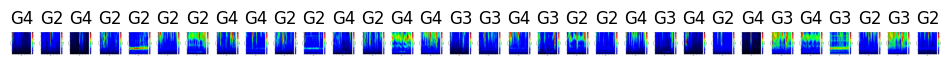

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Function to display a batch of images
def show_batch(images, labels, class_names=["G1", "G2", "G3", "G4"]):
    fig, axes = plt.subplots(1, len(images), figsize=(12, 4))
    for i, (image, label) in enumerate(zip(images, labels)):
        image = image.permute(1, 2, 0).numpy()  # Convert from CxHxW to HxWxC
        ax = axes[i]
        ax.imshow(image)
        ax.set_title(class_names[label])
        ax.axis('off')
    plt.show()

# Get a batch of images and labels from the train_loader
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Show a batch of images
show_batch(images, labels)
